In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import os
import dotenv
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mongo connection, extract and normalize

In [2]:
dotenv.load_dotenv()
MGURL = os.getenv("MGURL")
myclient = MongoClient(f"{MGURL}")
db = myclient.github

In [3]:
git = list(db.profiles.find({},{"_id":0, "company":0, "location":0, "email":0, "hireable":0}))

In [4]:
df = pd.json_normalize(git, "repos", ["name","repos_number","followers","created","updated"])

### Clean and prepare dataframe

In [5]:
df.created = df.created.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.updated = df.updated.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.language = df.language.str.replace(r"Jupyter Notebook","Python")

In [6]:
df["years"] = df.updated.astype(int)-df.created.astype(int)
df.drop(columns={"created","updated"}, axis=1, inplace=True)
df.language.fillna("None", inplace=True)
df.name.fillna("None", inplace=True)

In [7]:
print(df.shape)
df.head() 

(532585, 9)


,repo_name,forked,stars,language,forks,name,repos_number,followers,years
0,AwesomeNER,False,6,Python,2,Tarun Sudhams,23,33,4
1,coding-interview-university,True,2,None,1,Tarun Sudhams,23,33,4
2,COMP2396-assignments,False,0,Java,0,Tarun Sudhams,23,33,4
3,Computer-and-Communication-Networks,False,0,Python,1,Tarun Sudhams,23,33,4
4,Costa-Rican-Household-Poverty-Level-Prediction,False,0,HTML,4,Tarun Sudhams,23,33,4


In [8]:
#the forked encoding is manual due to I want to give an ordinal value to forked / not forked repos
forked_dict = {True:0, False:1}
df.forked = df.forked.map(forked_dict)

labelencoder = LabelEncoder()
df.name = labelencoder.fit_transform(df.name)

In [9]:
gf = df.groupby(["name", "repos_number", "followers", "years", "forked","language"]).agg({"repo_name":"count", "stars":"sum", "forks":"sum"}).rename(columns={"repo_name":"repos_num"})

In [10]:
gf.head()

repos_num  stars  forks
name repos_number followers years forked language                           
0    18           2         3     1      None                2      0      0
                                         Python             16      0      2
1    43           14        7     0      JavaScript          1      0      0
                                         None                7      0      1
                                         PHP                 6      0      0

In [11]:
df_dumm = pd.get_dummies(gf.reset_index().rename(columns={"name":"user_id", "repos_number":"total_repos","repos_num":"repos_lan"}))

### Ready for unsupervised machine learning

In [12]:
print(df_dumm.shape)
df_dumm.head()

(174758, 336)


,user_id,total_repos,followers,years,forked,repos_lan,stars,forks,language_1C Enterprise,language_ABAP,...,language_Zephir,language_Zig,language_eC,language_mcfunction,language_nesC,language_ooc,language_q,language_sed,language_wdl,language_xBase
0,0,18,2,3,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,18,2,3,1,16,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,43,14,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,43,14,7,0,7,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,43,14,7,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#we will exclude the id and save it
user_id = df_dumm.user_id
X = df_dumm.drop(columns={"user_id"})

### Scale & Normalize

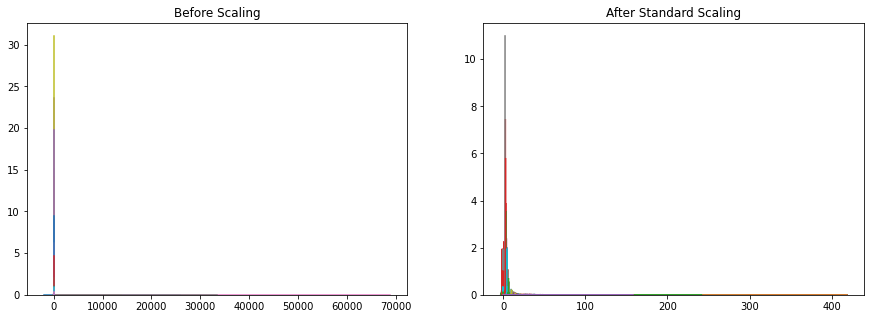

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

strans = scaler.fit_transform(X)

df_dumm_SS = pd.DataFrame(strans)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in df_dumm.columns:
    sns.kdeplot(df_dumm[e], ax=ax1, legend=False)
ax2.set_title('After Standard Scaling')
for e in df_dumm_SS.columns:
    sns.kdeplot(df_dumm_SS[e], ax=ax2, legend=False)
plt.show()

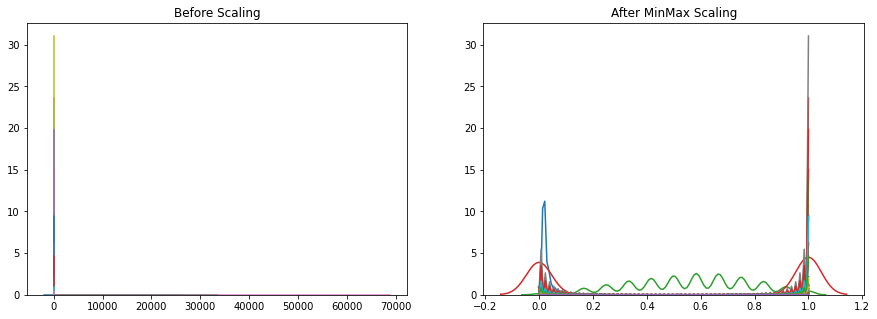

In [15]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

mtrans = minmax.fit_transform(X)

df_dumm_MM = pd.DataFrame(mtrans)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in df_dumm.columns:
    sns.kdeplot(df_dumm[e], ax=ax1, legend=False)
ax2.set_title('After MinMax Scaling')
for e in df_dumm_MM.columns:
    sns.kdeplot(df_dumm_MM[e], ax=ax2, legend=False)
plt.show()

### Check recommended clusters

In [25]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=20)

labels = model.fit_predict(df_dumm_MM)

In [26]:
df_dumm["label"] = labels

In [27]:
df_dumm.label.value_counts()

0     20740
17    16443
2     13458
11    12189
5     11672
3     10125
14     9368
8      8761
15     7929
4      7771
1      7765
7      7661
10     7610
6      7372
13     5176
12     5059
16     4762
18     4686
9      4205
19     2006
Name: label, dtype: int64

In [28]:
analysis = pd.crosstab([df_dumm.forked, df_dumm.total_repos, df_dumm.followers, df_dumm.years], df_dumm.label)
sns.heatmap(analysis, annot=True)

Error in callback <function flush_figures at 0x7fc809f4aa70> (for post_execute):


KeyboardInterrupt: 